In [61]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [62]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [63]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [64]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [65]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
9872,1697472000,1.05414,1.05436,1.05351,1.05375,4272,9,0
9873,1697473800,1.05374,1.05384,1.05277,1.05295,5124,9,0
9874,1697475600,1.05295,1.05399,1.05252,1.05390,4745,9,0
9875,1697477400,1.05390,1.05551,1.05384,1.05493,5198,9,0


In [66]:


def sma(df, lookback=50):
    df['sma'] = ta.sma(close=df['close'], length=lookback)
    return df

def rsi(df, lookback=14):
    df['rsi'] = ta.rsi(close=df['close'], length=lookback)
    return df


In [67]:

smalookback=50
rsilookback=2


df = sma(df, smalookback)
df = rsi(df, rsilookback)

df = df.dropna()

df


,time,open,high,low,close,tick_volume,spread,real_volume,sma,rsi
49,1672705800,1.06637,1.06649,1.06622,1.06635,160,31,0,1.067867,53.841808
50,1672707600,1.06643,1.06832,1.06497,1.06637,6050,7,0,1.067807,57.799127
51,1672709400,1.06637,1.06771,1.06633,1.06762,4286,7,0,1.067781,96.398238
52,1672711200,1.06762,1.06779,1.06665,1.06684,3472,7,0,1.067724,45.014655
53,1672713000,1.06684,1.06747,1.06677,1.06703,2445,7,0,1.067660,56.349872
...,...,...,...,...,...,...,...,...,...,...
9872,1697472000,1.05414,1.05436,1.05351,1.05375,4272,9,0,1.052161,51.952873
9873,1697473800,1.05374,1.05384,1.05277,1.05295,5124,9,0,1.052146,20.935965
9874,1697475600,1.05295,1.05399,1.05252,1.05390,4745,9,0,1.052182,67.300842
9875,1697477400,1.05390,1.05551,1.05384,1.05493,5198,9,0,1.052230,85.605291


In [68]:

buyIndices=[]
sellIndices=[]

buys=[]
sells=[]

position = None

sl = 0.5 / 100
tp = 1.5 / 100

slamount = None
tpamount = None

for i in range(len(df)):
    if (i > 0) and (position is None) and (df.iloc[i]['close'] > df.iloc[i]['sma']) and (df.iloc[i]['rsi'] < 5):
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
        slamount = df.iloc[i]['close'] - (sl * df.iloc[i]['close'])
        tpamount = df.iloc[i]['close'] + (tp * df.iloc[i]['close'])
    if (i > 0) and (position == 'long') and (
        (
            (df.iloc[i]['close'] < df.iloc[i]['sma']) and 
            (df.iloc[i]['rsi'] > 95)
        ) or (
            df.iloc[i]['close'] <= slamount
        ) or (
            df.iloc[i]['close'] >= tpamount
        )
    ):
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None
        slamount = None
        tpamount = None
        


In [69]:

print(buys)
print(sells)

print(buyIndices)
print(sellIndices)


[1.06314, 1.08347, 1.08262, 1.08546, 1.1003, 1.07345, 1.07505, 1.06769, 1.06042, 1.06465, 1.0623, 1.06701, 1.08688, 1.08372, 1.08927, 1.09185, 1.08984, 1.10543, 1.10167, 1.08644, 1.07853, 1.07291, 1.07776, 1.07938, 1.08927, 1.09012, 1.09633, 1.10144, 1.1219, 1.12192, 1.10182, 1.0984, 1.10183, 1.09696, 1.09221, 1.09179, 1.08771, 1.08214, 1.07437, 1.06823, 1.06967, 1.05178, 1.05432, 1.0575]
[1.08275, 1.0776, 1.08742, 1.10185, 1.09445, 1.07241, 1.06942, 1.06499, 1.05938, 1.05856, 1.05669, 1.06003, 1.0786, 1.08067, 1.09003, 1.08611, 1.10642, 1.09884, 1.09547, 1.08678, 1.0724, 1.07286, 1.07488, 1.0957, 1.09159, 1.08865, 1.09941, 1.11939, 1.12035, 1.11484, 1.09985, 1.09194, 1.09952, 1.09941, 1.09156, 1.08626, 1.08173, 1.07662, 1.07396, 1.06845, 1.06406, 1.05698, 1.05526, 1.05337]
[190, 397, 637, 1015, 1073, 1274, 1331, 1635, 1920, 2001, 2111, 2375, 2761, 2938, 3128, 3263, 3398, 3525, 4026, 4546, 4738, 4962, 5433, 5548, 5973, 6198, 6432, 6556, 6640, 6831, 7159, 7258, 7385, 7516, 7709, 7754, 7

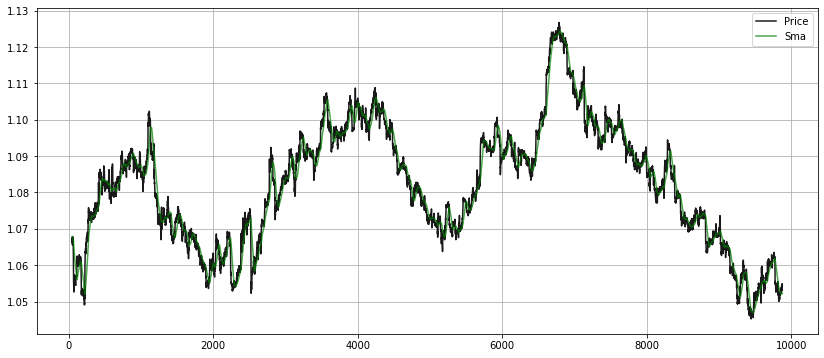

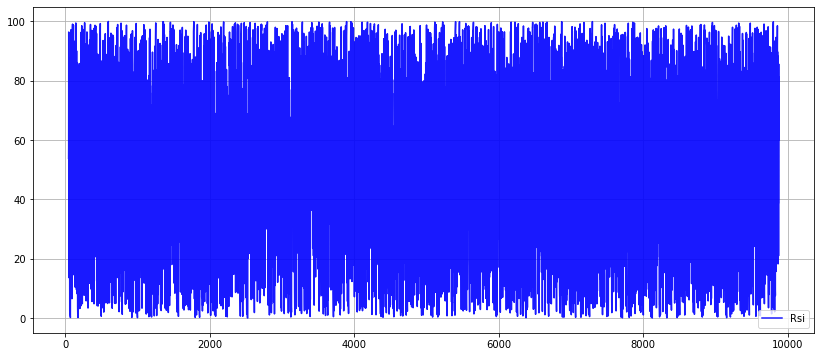

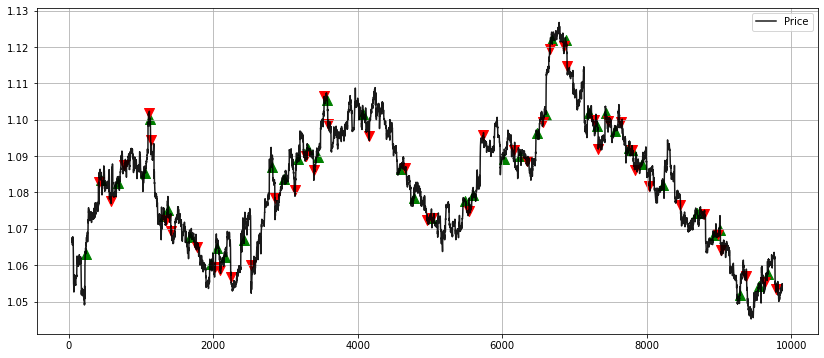

In [70]:




plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.plot(df['sma'], label='Sma', color='green', alpha=0.7)
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(df['rsi'], label='Rsi', color='blue', alpha=0.9)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()



In [71]:




brokerage = 1 / 100

wins = 0
losses = 0

profit = 0
loss = 0

averageprofit = 0
averageloss = 0

netresult = ''

for i in range(len(sells)):
    maximum = max(sells[i], buys[i])
    brokerageAmount = brokerage * maximum
    diff = sells[i] - buys[i] - brokerageAmount
    if (diff > 0):
        wins += 1
        profit += diff
    if (diff < 0):
        losses += 1
        loss += abs(diff)

if (profit > loss):
    netresult = 'Win'
elif (profit == loss):
    netresult = 'None'
else:
    netresult = 'Loss'

averageprofit = profit / wins
averageloss = loss / losses
hitratio = (wins / (wins + losses)) * 100
profitfactor = (profit / loss)
expectancy = (averageprofit * hitratio) - (averageloss * (1 - hitratio))
riskreward = (averageprofit / averageloss)

print(f'''
    Net result = {netresult}
    Hit ratio = {hitratio} %
    Profit factor = {profitfactor} {{currency}}
    Expectancy = {expectancy} {{currency}}
    Realised risk reward ratio = {riskreward} {{currency}}
''')







    Net result = Loss
    Hit ratio = 11.363636363636363 %
    Profit factor = 0.05985618202633105 {currency}
    Expectancy = 0.21337577972027988 {currency}
    Realised risk reward ratio = 0.4668782198053822 {currency}

